# Cross-correlation
In this notebook we show how the CCF works and how to interpret the CCF- and Kp-V$_{sys}$-maps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from redcross import Datacube, Planet, Template, CCF

### Load reduced data
We'll work with a reduced datacube with the main orders of HARPS-N (check out [previous notebooks](https://redcross.readthedocs.io/en/latest/notebooks/data_reduction.html) to learn about the reduction process).

In [3]:
data_dir = 'data/'
dc = Datacube().load(data_dir+'datacube_reduced_orders30-41.npy')
print('shape = {:}'.format(dc.shape))
# Shift to barycentric frame
dc.to_bary_frame()
print(dc.shape)

Loading Datacube from... data/datacube_reduced_orders30-41.npy
shape = (12, 247, 4096)
(12, 247, 4096)


### Load atmospheric template
Let's load an Fe emission template generated with petitRADTRANS (check out Notebook XX for more info on the template).

In [4]:
# Load template
template_path = data_dir + 'Fe_tea_template.npy' 
twave, tflux = np.load(template_path)
    
template = Template(wlt=twave, flux=tflux).sort().convolve_instrument(res=115e3)

## Cross-Correlation function
The CCF is computed for each spectrum (row of our datacube) over a range of RV-shifts as defined in the `RVt` vector. For each shift $RV$ we have

$$
\text{CCF} (RV) = \sum_i \frac{R_i · m_i(RV)}{\sigma_i^2}
$$
where the sum is over wavelength channels $i$. An efficient way to calculate the CCF is using a *dot product* between the *weighted data* $R_i / \sigma_i^2$ and $m_i(v)$ (see [numpy.dot()](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)). 



### Interpolation
The template is sampled onto the data wavelength grid and shifted for every RV value. This two steps can be performed in a single operation as shown belown 

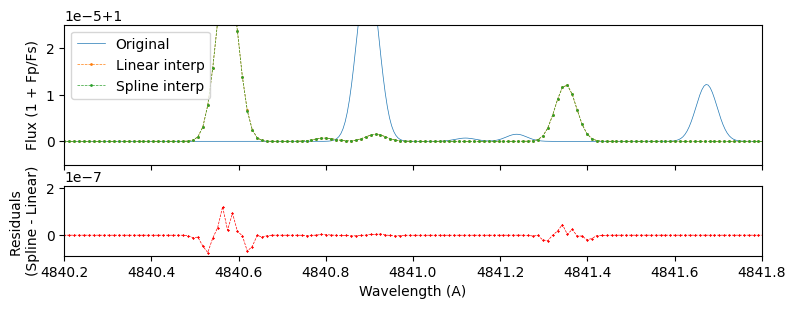

In [5]:
from scipy.interpolate import interp1d, splrep, splev

# Pick a wavevector from one order
wave_R = dc.order(0).wlt

# Define the RV-shift
delta_RV = 20. # km/s
c = 2.998e5 # km/s
beta = delta_RV/c
wShift = np.sqrt(((1-beta) / (1+beta)))
# Get the SHIFTED and RESAMPLED template
temp = template.copy().crop(wave_R.min(), wave_R.max()) # crop to a region around the selected order (speed up interpolation)

# 1) linear interpolation
m =  interp1d(temp.wlt*wShift, temp.flux)(wave_R)
# 2) *spline* interpolation
cs = splrep(temp.wlt*wShift, temp.flux)
m_spline = splev(wave_R, cs)

# Plot before and after
fig, ax = plt.subplots(2,1, figsize=(9,3), sharex=True, gridspec_kw={'height_ratios': [6,3]})
lw = 0.5
ax[0].plot(temp.wlt, temp.flux, lw=lw, label='Original')
ax[0].plot(wave_R, m, '--o', ms=1, lw=lw, label='Linear interp')
ax[0].plot(wave_R, m_spline, '--o', ms=1, lw=lw, label='Spline interp')

ax[1].plot(wave_R, (m_spline - m)/m_spline, '--xr', ms=1, lw=lw, label='Residuals')

ax[0].set(xlim=(4840.2, 4841.8), ylim=(0.999995, 1.000025), ylabel='Flux (1 + Fp/Fs)')
ax[0].legend()

ax[1].set( xlabel='Wavelength (A)', ylabel='Residuals \n(Spline - Linear)')

plt.show()

For models with resolution much higher than the data, **both interpolation methods yield very similar results**. Spline interpolation is *faster* because it is a two-step process: first it generates the B-spline decomposition of the input model once and then it projects it on the different *shifted* wavelength vectors (see [scipy.interpolate.splrep](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep))

#### Optimising the computation of the CCF-map
To speed up the CCF we can avoid using a loop over all RV-shifts by building a 2D-shifted-template matrix $S_{kj}$ with shape (nShifts, nPix), hence the CCF-map is generated in one multiplication

$$
\text{CCF}_{ik} = \frac{R_{ij}}{\sigma_{ij}^2} · S_{kj}^\mathrm{T}
$$
where $S_{kj}$ must be *transposed* so that the dot product is over the wavelength dimension. 

In the next cell we generate and display the $S_{kj}$ matrix.

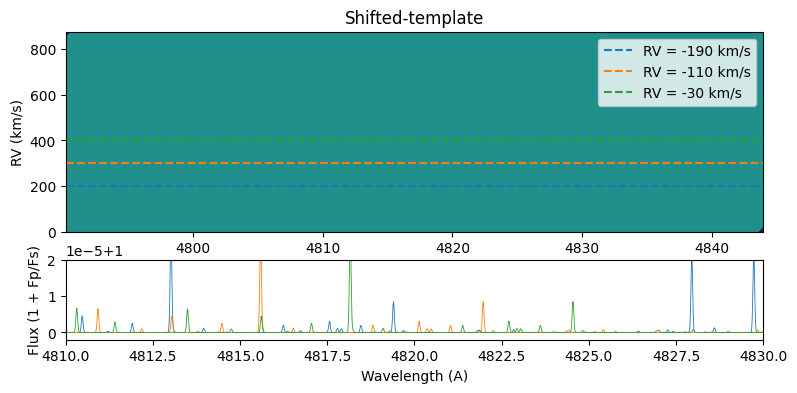

In [6]:
# Define RV-shift vector (km/s)
RVt = np.arange(-350, 351, 0.8)

# The output is a Datacube instance
temp2D = template.shift_2D(RVt, dc.order(0).wlt)

# Display the matrix (top) and three horizontal slices (bottom) i.e. 1D-templates shifted at different RVs
fig, ax = plt.subplots(2,1, figsize=(9, 4), gridspec_kw={'height_ratios': [5,2]})
temp2D.imshow(ax=ax[0])
c = 2.998e5
for row in np.linspace(200, 400, 3, dtype=int):
    ax[1].plot(temp2D.wlt*(1+temp2D.rv[row]/c), temp2D.flux[row], lw=0.6)
    ax[0].axhline(y=row, ls='--', c=plt.gca().lines[-1].get_color(), label='RV = {:.0f} km/s'.format(temp2D.rv[row]))

ax[0].set(ylabel='RV (km/s)', title='Shifted-template')

ax[1].set(xlabel='Wavelength (A)', ylabel='Flux (1 + Fp/Fs)', 
          xlim=(4810, 4830), ylim=(1. - 2*1e-6, 1+ 2*1e-5))
ax[0].legend()
plt.show()

#### Generating the CCF-map
The operations described above are performed in the function `ccf.run(datacube)` given an `RVt` vector and 1D-template `template` passed when creating the `CCF` instance.


The `CCF` object is an inherited class of `Datacube` so the same functions can be used, such as `imshow()` which correctly identifies the $x$-vector as $RV$ instead of wavelength. The values of the CCF can be accessed with the `flux` attribute (e.g. `ccf.flux`) and the RV-vector as `ccf.rv`.

CCF elapsed time: 2.00 s
mean nan -- std nan


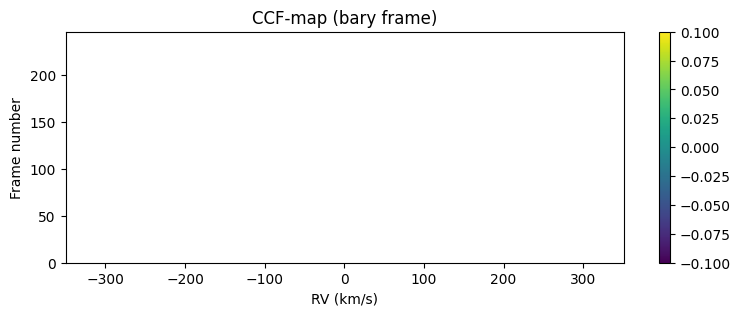

In [7]:
# merge all orders to have a datacube with shape (nFrames, nPix)
dcm = dc.merge_orders()

ccf = CCF(RVt, template).run(dcm)

# Plot the CCF-map
fig, ax = plt.subplots(1, figsize=(9, 3))

ccf.imshow(ax=ax, fig=fig) # passing a `fig` argument will display the colorbar

ax.set(xlabel='RV (km/s)', ylabel='Frame number', title='CCF-map ({:} frame)'.format(ccf.frame))
plt.show()

#### CCF-map to planetary frame
The previous map is computed in the frame of the passed `Datacube` (default = `telluric`). In the telluric (or stellar) frame, the planet trail changes in RV (as seen as a bright stripe in *emission* spectra). This trail becomes vertical in the planetary frame (where RV = 0). 

To shift to the planetary frame we can call the function `ccf.to_planet_frame(planet)` to shift every frame by the expected RV of the planet (via linear interpolation). In the following cell we display the CCF-map in the planetary frame and the *time-average* CCF.

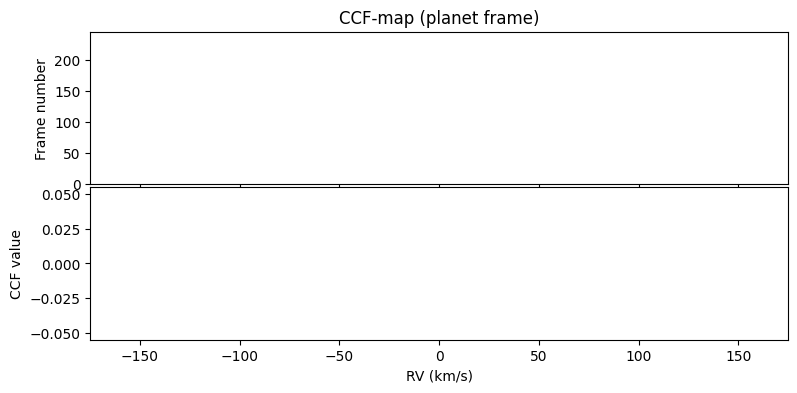

In [8]:
fig, ax = plt.subplots(2, figsize=(9, 4), sharex=True)

planet_file = 'data/wasp189.dat' 
planet = Planet(file=planet_file, **dc.header)

ccf_planet = ccf.to_planet_frame(planet, ax=ax[0])
ax[1].plot(ccf_planet.rv, np.median(ccf_planet.flux, axis=0))

ax[0].set(ylabel='Frame number', title='CCF-map ({:} frame)'.format(ccf_planet.frame))
ax[1].set(xlabel='RV (km/s)', ylabel='CCF value')
fig.subplots_adjust(hspace=0.02)

plt.show()

#### Extra: Additional plotting options

* 1) The y-axis can display the phase at each frame if the attribute `ccf.phase` is defined.

    `ccf.phase = planet.phase`
    
    
* 2) To identify the planet signal in the CCF-map it can be useful to overlap the expected RV-trail. Implemented by calling 

    `planet.trail(ax, frame)`


UnboundLocalError: local variable 'rvel' referenced before assignment

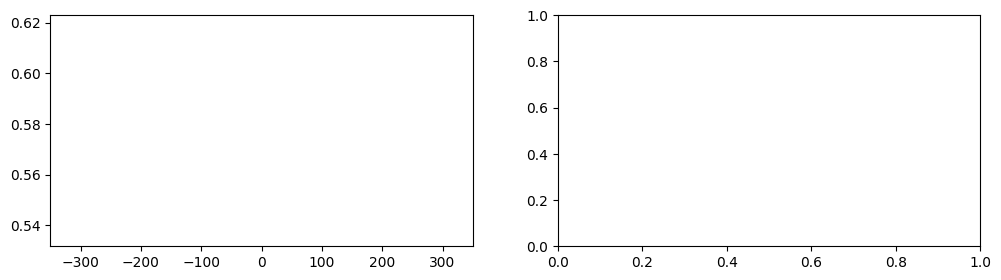

In [9]:
# Plot the CCF-map
fig, ax = plt.subplots(1,2, figsize=(12, 3))

for i,c in enumerate([ccf, ccf_planet]):
    c.phase = planet.phase
    c.imshow(ax=ax[i])
    
    planet.trail(ax=ax[i], frame=c.frame)

    ax[i].set(xlabel='RV (km/s)', ylabel='Phase', title='CCF-map ({:} frame)'.format(c.frame))
plt.show()